# Extracting distance between amino acids, contacts and attentions to train and test ML classifiers

## Import .py file

In [1]:
# Set path to directory containing .py files
# Import .py file to extract distance between amino acids, contacts and attentions
# All necessary packages are imported within the .py file

import sys
sys.path.append("../py")

# ESM-2 model for protein embeddings is esm.pretrained.esm2_t33_650M_UR50D()
from extract_contact_aa_distance_attentions import * 


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [2]:
# Ignore warnings when importing PDB structure files
warnings.simplefilter('ignore', PDBConstructionWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set variable for parsing PDB structural files
parser = PDBParser()  

## Extract Sequences from CASP7 Dataset

In [3]:
## Make sure to update directory paths from .py file prior to executing code

# Parse CASP training_95 file, extract all sequence IDs and sequences from dataset
# CASP training_95 file contains seed sequences for sequence clusters at 95% similarity

prot_data_dict = parse_casp7_file(casp_95)

for casp_id, casp_seq in list(prot_data_dict.items())[:3]:
    print(casp_id)
    print(casp_seq)
    print()

1RSO_2_B
GLLAAERAVSQVLDSLEEIHALTDSSEKDLDFLHSVFQDQHLHTLLDLYDKINTKS

3PCG_1_A
PIELLPETPSQTAGPYVHIGLALEAAGNPTRDQEIWNRLAKPDAPGEHILLLGQVYDGNGHLVRDSFLEVWQADANGEYQDAYNLENAFNSFGRTATTFDAGEWTLHTVKPGVVNNAAGVPMAPHINISLFARGINIHLHTRLYFDDEAQANAKCPVLNLIEQPQRRETLIAKRCEVDGKTAYRFDIRIQGEGETVFFDF

1YBD_1_A
MTQQIKYKRVLLKLSGESLMGSDPFGINHDTIVQTVGEIAEVVKMGVQVGIVVGGGNIFRGVSAQAGSMDRATADYMGMMATVMNALALKDAFETLGIKARVQSALSMQQIAETYARPKAIQYLEEGKVVIFAAGTGNPFFTTDTAAALRGAEMNCDVMLKATNVDGVYTADPKKDPSATRYETITFDEALLKNLKVMDATAFALCRERKLNIVVFGIAKEGSLKRVITGEDEGTLVHC



In [4]:
# CASP datasets contains sequence IDs that correspond to different chains in a sequence
# I.E. 1RSO_2_B refers to the 2nd part of chain B of the protein 1RSO

## To be sure I extract the CASP sequence that corresponds to the sequence in the 
# PDB structural file, I extract CASP IDs that occur once
# Which means that the stored sequence is the entire sequence for the protein
# This is because some sequences in the dataset only have a label for 1 chain

# Calculate occurence of sequence IDs
protein_id_counts = Counter(protein_id.split('_')[0] for protein_id in prot_data_dict)

# Store IDs that only occur once as single_occurence_ids
single_occurence_ids = [protein_id for protein_id, count in protein_id_counts.items() if count == 1]

print('Number of Unique IDs: ', len(single_occurence_ids), '\n')
print(single_occurence_ids[:5])

Number of Unique IDs:  8494 

['1YBD', '1PSM', '1DM0', '1WFO', '1YOA']


## Extract FASTA files from PDB database from identified CASP Protein IDs

In [5]:
## Take the IDs that occur once in the CASP training_95 dataset and extract the sequences
# from the PDB database. These sequences are used in generating PDB structural data.
# I.E. calculating arnstrong distance.

# for pdb_id in single_occurence_ids:
#     download_fasta(pdb_id, fasta_dir, downloadurl="https://www.rcsb.org/fasta/entry/")

# Load sequence ID and sequences from PDB into a dictionary
protein_data = load_fastas(fasta_dir)

print('Number of Sequences: ', len(protein_data), '\n')

for pdb_id, pdb_seq in list(protein_data.items())[:3]:
    print(pdb_id)
    print(pdb_seq)
    print()

Number of Sequences:  2682 

1C4R
GHAGTTYIFSKGGGQITYKWPPNDRPSTRADRLAIGFSTVQKEAVLVRVDSSSGLGDYLELHIHQGKIGVKFNVGTDDIAIEESNAIINDGKYHVVRFTRSGGNATLQVDSWPVIERYPAGRQLTIFNSQATIIIGGKEQGQPFQGQLSGLYYNGLKVLNMAAENDANIAIVGNVRLVGEVP

1UE8
MYDWFKQMRKESPVYYDGKVWNLFKYEDCKMVLNDHKRFSSNLTGYNDKLEMLRSGKVFFDIPTRYTMLTSDPPLHDELRNLTADAFNPSNLPVDFVREVTVKLLSELDEEFDVIESFAIPLPILVISKMLGINPDVKKVKDWSDLVALRLGRADEIFSIGRKYLELISFSKKELDSRKGKEIVDLTGKIANSNLSELEKEGYFILLMIAGNETTTNLIGNAIEDFTLYNSWDYVREKGALKAVEEALRFSPPVMRTIRVTKEKVKIRDQVIDEGELVRVWIASANRDEEVFKDPDSFIPDRTPNPHLSFGSGIHLCLGAPLARLEARIALEEFAKKFRVKEIVKKEKIDNEVLNGYRKLVVRVERT

1I24
MRGSHHHHHHGSRVMVIGGDGYCGWATALHLSKKNYEVCIVDNLVRRLFDHQLGLESLTPIASIHDRISRWKALTGKSIELYVGDICDFEFLAESFKSFEPDSVVHFGEQRSAPYSMIDRSRAVYTQHNNVIGTLNVLFAIKEFGEECHLVKLGTMGEYGTPNIDIEEGYITITHNGRTDTLPYPKQASSFYHLSKVHDSHNIAFTCKAWGIRATDLNQGVVYGVKTDETEMHEELRNRLDYDAVFGTALNRFCVQAAVGHPLTVYGKGGQTRGYLDIRDTVQCVEIAIANPAKAGEFRVFNQFTEQFSVNELASLVTKAGSKLGLDVKKMTVPNPRVEAEEHYYNAKHTKLMELGLEPHYLSDSLLDSLLNFAVQFKDRVDTKQIMPSVSWKKIGVKTKSMT

## Extract sequences that are the same in PDB database and CASP dataset

In [6]:
# Store sequence IDs that have sequences that are the same in both PDB database and
# CASP training_95 dataset
# Double checking if the sequences are uniform is important to ensure we are comparing
# the same proteins and chains that are the seed sequences in the CASP dataset clusters

same_sequence_ids = check_casp_pdb_seqs(protein_data)

print('Number of Uniform Sequences: ', len(same_sequence_ids), '\n')

Number of Uniform Sequences:  1215 



## Extract PDB structural data

In [ ]:
## Takes pdb_ids that have been extracted above and downloads the pdb structural file from
# the pdb database.
# These files will be used when generating contact sites.


# for pdb_id in same_sequence_ids:
#     download_pdb(pdb_id, structure_dir, downloadurl="http://files.rcsb.org/download/")



## Calculate distance between amino acids in the sequence and arnstrong distance between amino acids from PDB structural file

In [8]:
## To make sure we have a balanced number of contacts and non-contacts for each protein
# We make a subset of non-contact sites that are randomly selected and
# has the same number of amino acid pairs as in-contact sites

in_contact_sites, non_contact_sites, subset_non_contact_sites = contacts_per_pdb(same_sequence_ids,protein_data)

# Assuming in_contact_sites and subset_non_contact_sites are dictionaries
for sequence_id_in_contact, sequence_id_non_contact in zip(list(in_contact_sites.keys())[:1], list(subset_non_contact_sites.keys())[:1]):
    # If you want to process only 'in_contact_sites'
    for instance in random.sample(in_contact_sites[sequence_id_in_contact], 3):
        print(instance)

for instance in random.sample(subset_non_contact_sites[sequence_id_non_contact], 3):
    print(instance)


{'res_1': 22, 'res_2': 15, 'sig_1': 'N', 'sig_2': 'Y', 'aa_dist': 7, 'arn_dist': 4.920925, 'in_contact': True}
{'res_1': 281, 'res_2': 256, 'sig_1': 'W', 'sig_2': 'R', 'aa_dist': 25, 'arn_dist': 4.263388, 'in_contact': True}
{'res_1': 336, 'res_2': 333, 'sig_1': 'K', 'sig_2': 'E', 'aa_dist': 3, 'arn_dist': 4.824011, 'in_contact': True}
{'res_1': 282, 'res_2': 234, 'sig_1': 'I', 'sig_2': 'Y', 'aa_dist': 48, 'arn_dist': 26.498466, 'in_contact': False}
{'res_1': 311, 'res_2': 102, 'sig_1': 'G', 'sig_2': 'V', 'aa_dist': 209, 'arn_dist': 29.633726, 'in_contact': False}
{'res_1': 259, 'res_2': 31, 'sig_1': 'R', 'sig_2': 'M', 'aa_dist': 228, 'arn_dist': 12.578446, 'in_contact': False}


In [9]:
# Store in_contact dictionary and subset of non_contact dictionary as a single dictionary
# which will be used in ML train/test split

# Some sequences chains that are found to have no contacts are removed from the dictionary

contact_data = generate_contact_data(in_contact_sites, subset_non_contact_sites)

print('Number of sequences: ', len(contact_data))

Number of sequences:  1102


## Collect X, y data for ML model training

In [10]:
# Randomly select sequences from same_sequence_ids to reduce computational demand for training
seed_value = 67
random.seed(seed_value)
n_sequences = 300

sequence_ids = random.sample(same_sequence_ids, n_sequences)
# sequence_ids = same_sequence_ids
print('n_sequences: ', n_sequences)
print(sequence_ids[:5])

n_sequences:  300
['1BUE', '1FK5', '1QK9', '1PPQ', '1T5Q']


In [11]:
# The following function takes sequence IDs, generates ESM-2 embeddings, takes instances
# from contact_data, extracts combinations of residue 1 and residue 2, extracts attentions
# from all of the layers and heads for these combinations and extracts whether the residues 
# are in contact or not from earlier arnstrong distance calculations. 

# Attention vectors are stored as X, and residue contact values (True/False) are stored as Y
# Iterations represent how many sequences have been iterated through in the function
# Iterations = n_sequences

X, y = output_x_y(sequence_ids, contact_data, protein_data)

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Iteration:  51
Iteration:  52
Iteration:  53
Iteration:  54
Iteration:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59
Iteration:  60
Iteration:  61
Iteration:  62
Iteration:  63
Iteration:  64
Iteration:  65
Iteration:  66
Itera

In [12]:
# Train/Test split
# Previous experiment suggests test_size = 0.4 is optimal for best performance
# Due to subseting non-contact instances to be = to in-contact instances
# number of positive cases == number of negative cases

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, random_state=42)

print('Number of Amino Acid Instances: ', len(X_train))
print('Number of positive instances: ', round(len(X_train)/2))

Number of Amino Acid Instances:  9699
Number of positive instances:  4850


## Train Models

In [15]:
# Model hyperparameters optimized using Grid-Search CV on 300 randomly selected sequences
# 9,699 amino acid instances

# Train Random Forest Classifier

rf_clf = RandomForestClassifier(criterion='gini', max_depth=8,max_features='sqrt',n_estimators = 200,random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [16]:
# Test models on same train/test data to be sure of no data bias

y_pred = rf_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Random Forest Accuracy:", accuracy)
print("Random Forest Precision:", precision)
print("Random Forest Recall:", recall)

Random Forest Accuracy: 0.8980980361837019
Random Forest Precision: 0.89086996618506
Random Forest Recall: 0.9050593379138039


In [17]:
# Model hyperparameters optimized using Grid-Search CV on 300 randomly selected sequences
# 9,699 amino acid instances

# Train Linear SVC

linear_svc = LinearSVC(C=10, class_weight='balanced', dual=True, loss='hinge',max_iter=200000)
linear_svc.fit(X_train, y_train)

LinearSVC(C=10, class_weight='balanced', dual=True, loss='hinge',
          max_iter=200000)

In [18]:
y_pred = linear_svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Linear SVC Accuracy:", accuracy)
print("Linear SVC Precision:", precision)
print("Linear SVC Recall:", recall)

Linear SVC Accuracy: 0.8810886036802227
Linear SVC Precision: 0.9213716660893662
Linear SVC Recall: 0.8307307932542161


In [19]:
# Model hyperparameters optimized using Grid-Search CV on 300 randomly selected sequences
# 9,699 amino acid instances

# Train Logistic Regression

lr_clf = LogisticRegression(C=100, max_iter=200000, solver='saga')
lr_clf.fit(X_train, y_train)

LogisticRegression(C=100, max_iter=200000, solver='saga')

In [20]:
y_pred = lr_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression Precision:", precision)
print("Logistic Regression Recall:", recall)

Logistic Regression Accuracy: 0.8764496675429102
Logistic Regression Precision: 0.9147393855712806
Logistic Regression Recall: 0.8276077451592755


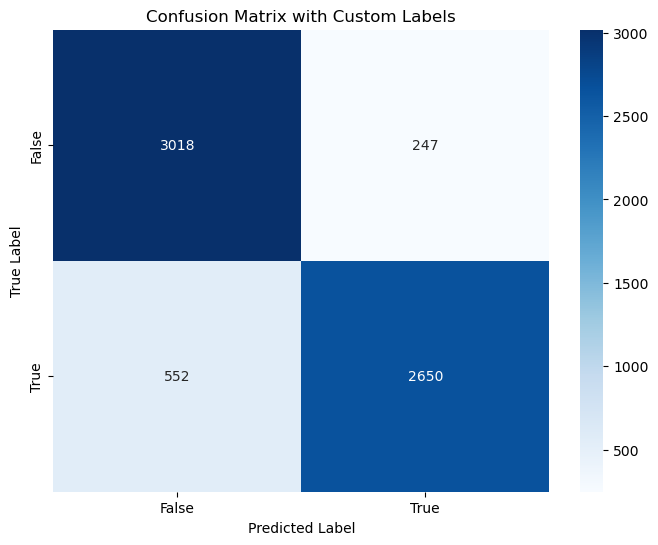

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')

# Axis labels
tick_marks = np.arange(2) + 0.5
plt.xticks(tick_marks, ['False', 'True'])
plt.yticks(tick_marks, ['False', 'True'], va='center')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Custom Labels')
plt.show()

## Test a randomly generated sequence against trained models

In [83]:
# List of standard amino acids (excluding stop codons)
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 
               'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

# Generate a random sequence of 300 amino acids
random_seq = ''.join(random.choices(amino_acids, k=300))

rand_protein_data = {}
rand_protein_data['random1'] = random_seq

In [84]:
# Get random sequence embedding

random_embedding = generate_embeddings('random1',rand_protein_data)

In [91]:
# Get random sequence embeddings

random_x = []

for res_1 in random.sample(range(300),80):
    for res_2 in random.sample(range(300),80):
        if res_1==res_2:
            continue
        else:
#             print(res_1,res_2)
            random_x.append(get_x_y(random_embedding, res_1, res_2))

In [92]:
# Take a subset of amino acid pair instances
n = 5000
random_x_test = random.sample(random_x, n)

In [93]:
# Make predictions

rf_rand_y_pred = rf_clf.predict(random_x_test)
lr_rand_y_pred = lr_clf.predict(random_x_test)
svc_rand_y_pred = linear_svc.predict(random_x_test)

In [94]:
rf_false_count = 0
rf_true_count = 0

for i in rf_rand_y_pred:
    if i == False:
        rf_false_count+=1
    else:
        rf_true_count+=1

rf_accuracy = rf_false_count/n*100
print(f'Random Forest Accuracy: {rf_accuracy}%')

Random Forest Accuracy: 87.12%


In [95]:
lr_false_count = 0
lr_true_count = 0

for i in lr_rand_y_pred:
    if i == False:
        lr_false_count+=1
    else:
        lr_true_count+=1

lr_accuracy = lr_false_count/n*100
print(f'Logisitc Regression Accuracy: {lr_accuracy}%')

Logisitc Regression Accuracy: 96.82%


In [96]:
svc_false_count = 0
svc_true_count = 0

for i in svc_rand_y_pred:
    if i == False:
        svc_false_count+=1
    else:
        svc_true_count+=1

svc_accuracy = svc_false_count/n*100
print(f'Linear SVC Accuracy: {svc_accuracy}%')

Linear SVC Accuracy: 97.76%
